In [1]:
### running GMM on synthetic DSD data to see how many classes fall out
# dduncan, october 10 2018


from sklearn import mixture
import random
plt.style.use('bmh') #ggplot')

nc = 4
nel = 800  # number of elements in synthetic dataset

# define GMM object
gmm = mixture.GaussianMixture(n_components = nc, covariance_type = 'full')


In [2]:
def marshall_dist(Dvec,RR):
    """
     Calcuate the Marshall Palmer drop size distribution

     Input: Dvec: vector of diameters in mm
            RR: rain rate in mm/hr
     output: n(Dvec), length of Dvec, in m^{-3} mm^{-1}
    """
    N0=8000.0  #m^{-3} mm^{-1}
    the_lambda= 4.1*RR**(-0.21)
    output=N0*np.exp(-the_lambda*Dvec)
    return output

In [3]:
def mgd(in_D,in_Dm,in_mu,in_Nw):
    """
     Calcuate the Modified Gamma drop size distribution

     Input (note, all inputs should be vectors of same size!) : 
            in_D:  vector of diameters [mm]
            in_Dm: mass-weighted mean diameter [mm]
            in_mu: shape parameter [dim-less]
            in_Nw: normalized intercept parameter [IN LOG10()!!] [mm-1 m-3]
     output: N(D) [len(in_D)] in m^{-3} mm^{-1}
    """
    if(len(in_D)==1):
        print("need to input vector for in_D")
    enot = 10**in_Nw
    eff = 6/(4**4) * ((4+in_mu)**(4+in_mu) ) / math.gamma(4+in_mu)
    ModGam = enot * eff * (in_D/in_Dm)**in_mu * np.exp(-(4+in_mu)*in_D/in_Dm)
    return ModGam

In [4]:
bn = np.load('/home/dudavid/projects/dsd/oceanrain_binsizes.npy')[12:] # load OR bin limits
mpy = bn[0:70] #np.array([float(bn[x]) for x in range(70)]) # drop size diameter bins [mm]
# for calculating theoretical DSDs below

# define MP N(D) 
mprr = 1.0 # mp rain rate
#marshp1 = 8000.0*np.exp(-4.1*mprr**(-0.21) *mpy) # MP for RR=Xmm/h
marshp1 = marshall_dist(mpy, mprr) # MP for RR=Xmm/h
print(info(marshp1))

# define MGD
# gamma(4) = 6
muu = 2
Dem = 1.5 # in mm
#enot = 10**(3.5) # note No* usually seen as log10()
#eff = 6/(4**4) * ((4+muu)**(4+muu) ) / math.gamma(4+muu) 
mgd_test = mgd(mpy,Dem, muu, 3.5)
print(info(mgd_test))

['1.81E-8', '1.62E+3', '1.56E+2', '3.48E+2']
['2.38E-6', '4.33E+2', '1.06E+2', '1.52E+2']


In [14]:
syn_rr = [np.exp(9*(0.48-random.random())) for x in range(nel)]
print(info(syn_rr))

mp_syn = np.array([ marshall_dist(mpy,r) for r in syn_rr])
#print(mp_syn[232,:])

syn_nw = [3.7+0.6*(random.normalvariate(0,1)) for x in range(nel)]
syn_dm = [1.75+0.35*(random.normalvariate(-.1,.9)) for x in range(nel)]
#print(info(syn_nw))
print(info(syn_dm))
#mgd_syn = np.array([mgd(mpy, en, muu, 3.8) for en in syn_dm])
mgd_syn = np.array([mgd(mpy, syn_dm[en], muu, syn_nw[en]) for en in range(len(syn_nw))])
#mgd_syn = np.array([mgd(mpy, Dem, muu, en) for en in syn_nw])

['9.76E-3', '7.50E+1', '8.45E+0', '1.50E+1']
['6.52E-1', '2.84E+0', '1.73E+0', '3.24E-1']


In [6]:
# normies
# to normalize based on total RWC (say), need to multiply # per bin per mm by 
#  the mass per bin and mm
dD = [mpy[n+1]-mpy[n] for n in range(len(mpy)-1)] # bin width [diameter, mm]
#print(dD)
norm_fac = 1000.0 * (4/3 * np.pi * (mpy[:-1]*.5)**3) * dD
#print(norm_fac)
#for s in range(nel):
#    interm_mpsyn = norm_fac * mp_syn[s,:] / np.sum()
mp_syn_norm = np.array([norm_fac * mp_syn[s,:-1] / np.sum(norm_fac * mp_syn[s,:-1]) for s in range(nel)])
mgd_syn_norm = np.array([norm_fac * mgd_syn[s,:-1] / np.sum(norm_fac * mgd_syn[s,:-1]) for s in range(nel)])
print(np.sum(mp_syn_norm[323,:]))
print(np.sum(mgd_syn_norm[323,:]))

1.0
0.9999999999999997


rrs:  5.275548422065605
rrs:  0.014945227927437021
rrs:  48.06184479496007
rrs:  0.919047603628277
rrs:  0.19412129770732084
rrs:  0.18073346368107154
rrs:  0.010255068823871246
rrs:  0.04015405502437074
rrs:  0.24466583328212493
rrs:  17.13715812081305


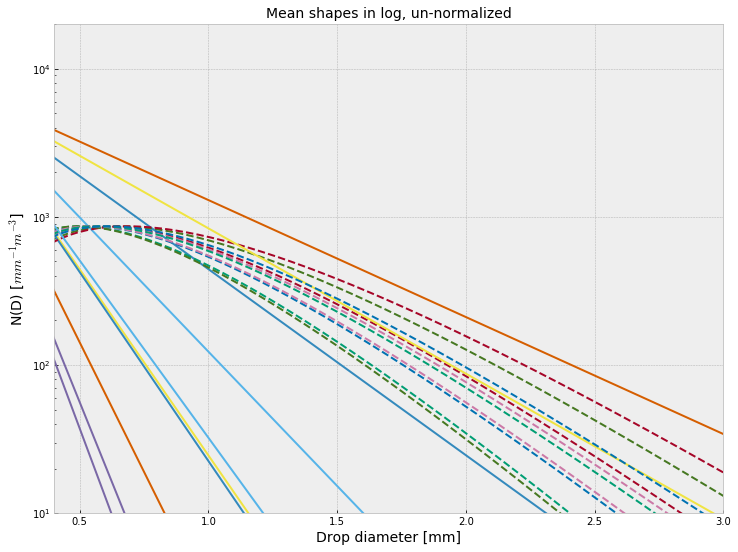

In [7]:


plt.figure(figsize=[12,9])
for x in range(10):
    plt.plot(mpy, mp_syn[x,:])
    plt.plot(mpy, mgd_syn[x,:], linestyle='--')
    #, label='MGD (Dm='+str(Dem)+', Nw='+str(np.log10(enot))+', mu='+str(muu), linestyle='-.')
    print('rrs: ',syn_rr[x])

fs= 14
#plt.yticks(y[::ysb],strbs[::ysb],fontsize=fs)
plt.legend(fontsize=fs)
plt.xlabel("Drop diameter [mm]",fontsize=fs)
plt.ylabel(r"N(D) [$mm^{-1} m^{-3}$]",fontsize=fs)
plt.yscale('log')
plt.title('Mean shapes in log, un-normalized',fontsize=fs)
plt.ylim([1e1, 2e4])
#plt.ylim([0, 50])
plt.xlim([0.4, 3])

plt.show()

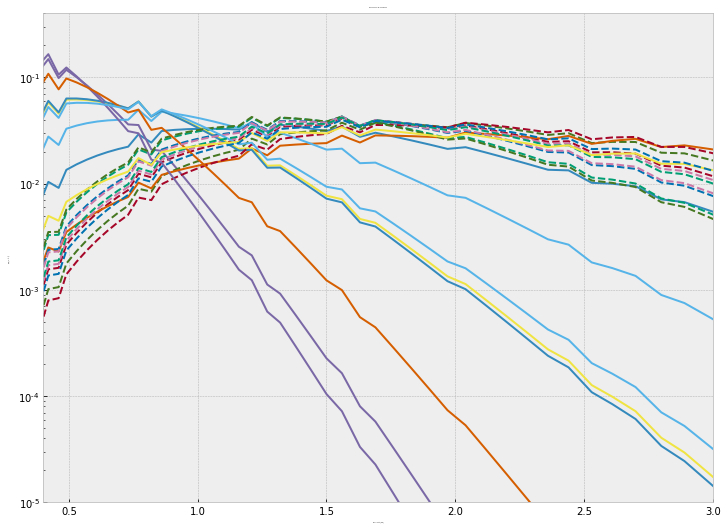

In [8]:


plt.figure(figsize=[12,9])
for x in range(10):
    plt.plot(mpy[:-1], mp_syn_norm[x,:])
    plt.plot(mpy[:-1], mgd_syn_norm[x,:], linestyle='--')
    #, label='MGD (Dm='+str(Dem)+', Nw='+str(np.log10(enot))+', mu='+str(muu), linestyle='-.')
    #print(syn_rr[x])

fs= 1
#plt.yticks(y[::ysb],strbs[::ysb],fontsize=fs)
plt.legend(fontsize=fs)
plt.xlabel("Drop diameter [mm]",fontsize=fs)
plt.ylabel(r"N(D) [$mm^{-1} m^{-3}$]",fontsize=fs)
plt.yscale('log')
plt.title('Mean shapes in log, un-normalized',fontsize=fs)
plt.ylim([1e-5, 4e-1])
#plt.ylim([0, 50])
plt.xlim([0.4, 3])

plt.show()

In [9]:
#enw = nw.reshape(len(nw),1)
#err = rr.reshape(len(rr),1)
#obj = np.hstack([cts_new[:first,:], enw[:first,:] , err[:first,:]])
obj = mp_syn 
obj = np.vstack([mp_syn, mgd_syn])
print(np.shape(obj))


gmm.fit(obj)

post_prob = gmm.predict_proba(obj)
labels = gmm.predict(obj)

bic_score = gmm.bic(obj)
print('BIC score: ', bic_score)

means = np.squeeze(gmm.means_)
print(np.shape(means))

(1600, 70)
BIC score:  -1090918.203137836
(4, 70)


In [10]:
# can run the BIC calculator for 1 to nb regimes here (takes a while)
nb = 14
#if run_bic:
#    for b in range(nb):
#        gmm = None
#        gmm = mixture.GaussianMixture(n_components = b+1, covariance_type = 'diag')
#        gmm.fit(obj)
#        bic_score = gmm.bic(obj)
#        print('BIC score, ncomp = ',str(b+1),': ', '{:.2e}'.format(bic_score))

#print(means)

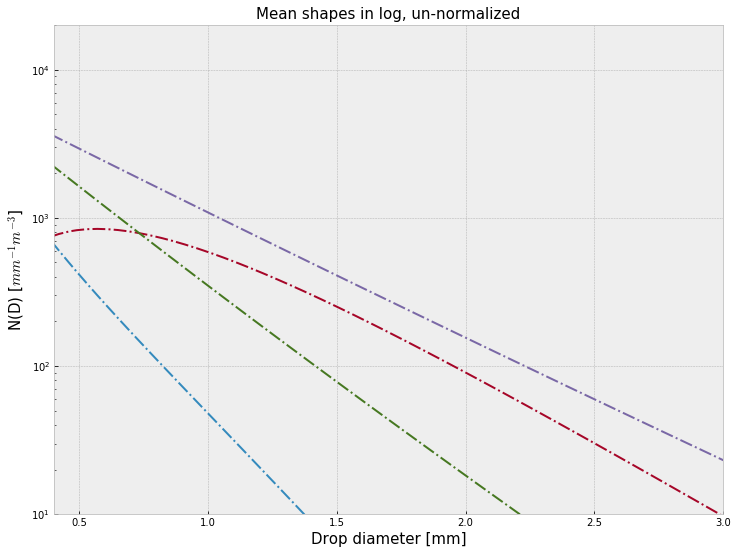

In [13]:


plt.figure(figsize=[12,9])
#for x in range(5):
#    plt.plot(mpy[:-1], mp_syn[x,:-1])
#    plt.plot(mpy[:-1], mgd_syn[x,:-1], linestyle='--')
#    #, label='MGD (Dm='+str(Dem)+', Nw='+str(np.log10(enot))+', mu='+str(muu), linestyle='-.')
#    #print(syn_rr[x])

for x in range(nc):
    plt.plot(mpy[:-1], means[x,:-1],linestyle='-.')
    
fs= 15
#plt.yticks(y[::ysb],strbs[::ysb],fontsize=fs)
plt.legend(fontsize=fs)
plt.xlabel("Drop diameter [mm]",fontsize=fs)
plt.ylabel(r"N(D) [$mm^{-1} m^{-3}$]",fontsize=fs)
plt.yscale('log')
plt.title('Mean shapes in log, un-normalized',fontsize=fs)
plt.ylim([1e1, 2e4])
#plt.ylim([1e-5, 4e-1])
#plt.ylim([0, 50])
plt.xlim([0.4, 3])

plt.show()